# MODELO

In [ ]:
!pip install pydicom
!pip install efficientnet

     |████████████████████████████████| 1.9MB 18.5MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 


In [ ]:
import os

import cv2
# import pydicom
import pandas as pd
import numpy as np 
# from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm 
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D,
    Add, Conv2D, AveragePooling2D, Concatenate, GaussianNoise
)
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
import tensorflow.keras.applications as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold

from google.colab import drive

In [ ]:
drive.mount('/content/drive')
BASE_FOLDER = '/content/drive/My Drive/TFM/'
BASE_CSV_DATA = BASE_FOLDER + 'osic-pulmonary-fibrosis-progression/'

Mounted at /content/drive


# Training Parameters


In [ ]:
train = pd.read_csv(BASE_CSV_DATA + 'train.csv')
display(train.head())
test = pd.read_csv(BASE_CSV_DATA + 'test.csv')
display(test.head())

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [ ]:
print('len train', len(train))
print('len test', len(test))

len train 1549
len test 5


## Tratamiento csv

- Añadir datos base
- Codificar valores categóricos
- Normalizar numéric

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder

oe = OrdinalEncoder()
scaler = MinMaxScaler()
oh = OneHotEncoder()

train['df_type'] = 'train'
test['df_type'] = 'test'
new_df = train.append(test)

new_df['Sex_M'] = [1 if item == 'male' else 0 for item in new_df['Sex']]
new_df['Sex_F'] = [1 if item == 'female' else 0 for item in new_df['Sex']]
new_df['SmokingStatus_Ex'] = [1 if item == 'Ex-smoker' else 0 for item in new_df['SmokingStatus']]
new_df['SmokingStatus_N'] = [1 if item == 'Never smoked' else 0 for item in new_df['SmokingStatus']]
new_df['SmokingStatus_S'] = [1 if item == 'Currently smokes' else 0 for item in new_df['SmokingStatus']]
new_df['Patient_by_week'] = [item[0] + '_' + str(item[1]) for item in new_df.values]
new_df['min_week'] = new_df['Weeks']
new_df['min_week'] = new_df.groupby('Patient')['min_week'].transform('min')

base = new_df.loc[new_df.Weeks == new_df.min_week]
base = base[['Patient', 'FVC']].copy()
base.columns = ['Patient', 'base_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

new_df = new_df.merge(base, on='Patient', how='left')
new_df['base_week'] = new_df['Weeks'] - new_df['min_week']

new_df[['Percent', 'Age', 'base_FVC']] = scaler.fit_transform(new_df[['Percent', 'Age', 'base_FVC']])

del new_df['Sex']
del new_df['SmokingStatus']

col = new_df[['Patient', 'Patient_by_week']]
oe = OrdinalEncoder()
oe.fit(col)
new_df[['Patient', 'Patient_by_week']] = oe.transform(col)

new_train = new_df.loc[new_df.df_type=='train']
del new_train['df_type']
display(new_train.head())
new_test = new_df.loc[new_df.df_type=='test']
del new_test['df_type']
display(new_test.head())



,Patient,Weeks,FVC,Percent,Age,Sex_M,Sex_F,SmokingStatus_Ex,SmokingStatus_N,SmokingStatus_S,Patient_by_week,min_week,base_FVC,base_week
0,0.0,-4,2315,0.236393,0.769231,0,0,1,0,0,0.0,-4,0.241456,0
1,0.0,5,2214,0.215941,0.769231,0,0,1,0,0,5.0,-4,0.241456,9
2,0.0,7,2061,0.184960,0.769231,0,0,1,0,0,7.0,-4,0.241456,11
3,0.0,9,2144,0.201767,0.769231,0,0,1,0,0,8.0,-4,0.241456,13
4,0.0,11,2069,0.186580,0.769231,0,0,1,0,0,1.0,-4,0.241456,15


,Patient,Weeks,FVC,Percent,Age,Sex_M,Sex_F,SmokingStatus_Ex,SmokingStatus_N,SmokingStatus_S,Patient_by_week,min_week,base_FVC,base_week
1549,171.0,6,3020,0.332421,0.615385,0,0,1,0,0,1504.0,6,0.372400,0
1550,172.0,15,2739,0.427848,0.487179,0,0,1,0,0,1507.0,15,0.320208,0
1551,173.0,6,1930,0.384612,0.615385,0,0,1,0,0,1523.0,6,0.169948,0
1552,174.0,17,3294,0.405425,0.589744,0,0,1,0,0,1524.0,17,0.423291,0
1553,175.0,0,2925,0.345604,0.615385,0,0,0,1,0,1533.0,0,0.354755,0


In [ ]:
new_train.keys()

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex_M', 'Sex_F',
       'SmokingStatus_Ex', 'SmokingStatus_N', 'SmokingStatus_S',
       'Patient_by_week', 'min_week', 'base_FVC', 'base_week'],
      dtype='object')

## Modelo multicapa

In [ ]:
results = new_train['FVC'].values
patientes_by_wwwwww = new_train[new_train.keys()].copy()
del patientes_by_wwwwww['FVC']
display(patientes_by_wwwwww)
len(results)

,Patient,Weeks,Percent,Age,Sex_M,Sex_F,SmokingStatus_Ex,SmokingStatus_N,SmokingStatus_S,Patient_by_week,min_week,base_FVC,base_week
0,0.0,-4,0.236393,0.769231,0,0,1,0,0,0.0,-4,0.241456,0
1,0.0,5,0.215941,0.769231,0,0,1,0,0,5.0,-4,0.241456,9
2,0.0,7,0.184960,0.769231,0,0,1,0,0,7.0,-4,0.241456,11
3,0.0,9,0.201767,0.769231,0,0,1,0,0,8.0,-4,0.241456,13
4,0.0,11,0.186580,0.769231,0,0,1,0,0,1.0,-4,0.241456,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,175.0,13,0.303514,0.615385,0,0,0,1,0,1535.0,0,0.354755,13
1545,175.0,19,0.356076,0.615385,0,0,0,1,0,1536.0,0,0.354755,19
1546,175.0,31,0.342244,0.615385,0,0,0,1,0,1537.0,0,0.354755,31
1547,175.0,43,0.355484,0.615385,0,0,0,1,0,1538.0,0,0.354755,43


1549

In [ ]:
inp2 = Input(shape=(13,), name='historial_medico')
x2 = Dense(128,activation='relu')(inp2)
x2 = Dense(64,activation='relu')(x2)
x2 = Dense(1,activation='relu')(x2)
model_solo_csv_base = Model(inp2 , x2)
model_solo_csv_base.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
historial_medico (InputLayer [(None, 13)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
inp2 = Input(shape=(13,), name='historial_medico')
x2 = Dense(128,activation='relu')(inp2)
x2 = Dense(64,activation='relu')(x2)
x2 = Dense(1,activation='relu')(x2)
model_solo_csv_base = Model(inp2 , x2)
model_solo_csv_base.compile(optimizer='adam', loss="mae")
H1 = model_solo_csv_base.fit(patientes_by_wwwwww,
                             results,
                             epochs=50,
                       validation_split=0.2,
                       batch_size=8)

KeyboardInterrupt: ignored

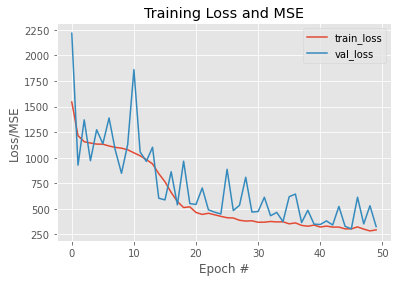

In [ ]:
import matplotlib.pyplot as plt
# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H1.history["val_loss"], label="val_loss")
plt.title("Training Loss and MSE")
plt.xlabel("Epoch #")
plt.ylabel("Loss/MSE")
plt.legend()

# Modelo multicapa modificado

In [ ]:
inp2 = Input(shape=(13,), name='historial_medico')
x2 = Dense(128,activation='relu')(inp2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.25)(x2)
x2 = Dense(64,activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(1,activation='relu')(x2)
model_solo_csv_over1 = Model(inp2 , x2)
model_solo_csv_over1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
historial_medico (InputLayer [(None, 13)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0   

In [ ]:
inp2 = Input(shape=(13,), name='historial_medico')
x2 = Dense(128,activation='relu')(inp2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.25)(x2)
x2 = Dense(64,activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(1,activation='relu')(x2)
model_solo_csv_over1 = Model(inp2 , x2)
model_solo_csv_over1.compile(optimizer='adam', loss="mae")
H5 = model_solo_csv_over1.fit(patientes_by_wwwwww,
                             results,
                             epochs=50,
                       validation_split=0.2,
                       batch_size=8)

Epoch 1/50
155/155 [==============================] - 1s 3ms/step - loss: 2673.7590 - val_loss: 2589.4021
Epoch 2/50
155/155 [==============================] - 0s 2ms/step - loss: 2682.4952 - val_loss: 2565.5134
Epoch 3/50
155/155 [==============================] - 0s 2ms/step - loss: 2651.9502 - val_loss: 2510.7161
Epoch 4/50
155/155 [==============================] - 0s 2ms/step - loss: 2668.2341 - val_loss: 2463.9546
Epoch 5/50
155/155 [==============================] - 0s 2ms/step - loss: 2631.3972 - val_loss: 2421.1521
Epoch 6/50
155/155 [==============================] - 0s 2ms/step - loss: 2575.6797 - val_loss: 2328.0627
Epoch 7/50
155/155 [==============================] - 0s 2ms/step - loss: 2521.0144 - val_loss: 2219.7544
Epoch 8/50
155/155 [==============================] - 0s 2ms/step - loss: 2554.9994 - val_loss: 2206.5327
Epoch 9/50
155/155 [==============================] - 0s 2ms/step - loss: 2419.0410 - val_loss: 2082.6592
Epoch 10/50
155/155 [=========================

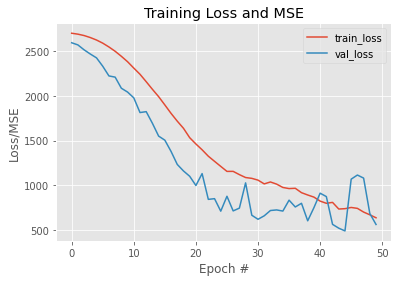

In [ ]:
import matplotlib.pyplot as plt
# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H5.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H5.history["val_loss"], label="val_loss")
plt.title("Training Loss and MSE")
plt.xlabel("Epoch #")
plt.ylabel("Loss/MSE")
plt.legend()

# CV Evaluation

In [ ]:
results_by_text = new_test['FVC'].values
patientes_by_test = new_test[new_test.keys()].copy()
del patientes_by_test['FVC']
display(patientes_by_test)
len(results_by_text)

,Patient,Weeks,Percent,Age,Sex_M,Sex_F,SmokingStatus_Ex,SmokingStatus_N,SmokingStatus_S,Patient_by_week,min_week,base_FVC,base_week
1549,171.0,6,0.332421,0.615385,0,0,1,0,0,1504.0,6,0.372400,0
1550,172.0,15,0.427848,0.487179,0,0,1,0,0,1507.0,15,0.320208,0
1551,173.0,6,0.384612,0.615385,0,0,1,0,0,1523.0,6,0.169948,0
1552,174.0,17,0.405425,0.589744,0,0,1,0,0,1524.0,17,0.423291,0
1553,175.0,0,0.345604,0.615385,0,0,0,1,0,1533.0,0,0.354755,0


5

### Modelo inicial

---



In [ ]:
predictions = model_solo_csv_base.predict(patientes_by_test)
print(predictions)

[[2666.9631]
 [2663.7952]
 [2298.953 ]
 [2873.9106]
 [2382.9377]]


In [ ]:
model_solo_csv_base.evaluate(patientes_by_test, results_by_text)

1/1 [==============================] - 0s 15ms/step - loss: 351.8692


351.8692321777344

In [ ]:
for i in list(range(0, 5)):
  print(predictions[i], results_by_text[i], predictions[i] - results_by_text[i])

[2666.9631] 3020 [-353.03687]
[2663.7952] 2739 [-75.204834]
[2298.953] 1930 [368.95288]
[2873.9106] 3294 [-420.08936]
[2382.9377] 2925 [-542.06226]


### Modelo modificado

---



In [ ]:
predictions2 = model_solo_csv_over1.predict(patientes_by_test)
print(predictions2)

[[2457.1838]
 [2444.9072]
 [2363.186 ]
 [2498.1567]
 [2185.163 ]]


In [ ]:
model_solo_csv_over1.evaluate(patientes_by_test, results_by_text)

1/1 [==============================] - 0s 16ms/step - loss: 565.1550


565.155029296875

In [ ]:
for i in list(range(0, 5)):
  print(predictions2[i], results_by_text[i], predictions2[i] - results_by_text[i])

[2457.1838] 3020 [-562.81616]
[2444.9072] 2739 [-294.09277]
[2363.186] 1930 [433.18604]
[2498.1567] 3294 [-795.84326]
[2185.163] 2925 [-739.8369]


# Modelo2, red combinada con CNN


Elegimos 10 clientes aleatorios entre los que tengamos previamente guardadas sus imágenes ya procesadas

In [ ]:
train = pd.read_csv(BASE_CSV_DATA + 'train.csv')
patients_in_dir = os.listdir(BASE_FOLDER + 'train-scans/')
test = pd.read_csv(BASE_CSV_DATA + 'test.csv')
display(test.head())
random_patients = np.random.choice(patients_in_dir, size = 10)
random_patients = [item.split('.')[0] for item in random_patients]
np.array(random_patients)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


array(['ID00248637202266698862378', 'ID00060637202187965290703',
       'ID00365637202296085035729', 'ID00023637202179104603099',
       'ID00216637202257988213445', 'ID00370637202296737666151',
       'ID00279637202272164826258', 'ID00073637202198167792918',
       'ID00125637202218590429387', 'ID00128637202219474716089'],
      dtype='<U25')

In [ ]:
train['Patient'].isin(random_patients)

0       False
1       False
2       False
3       False
4       False
        ...  
1544    False
1545    False
1546    False
1547    False
1548    False
Name: Patient, Length: 1549, dtype: bool

In [ ]:
print('len pre', len(train))
train = train[train['Patient'].isin(random_patients)]
print('final len', len(train))

len pre 1549
final len 85


In [ ]:
train.Patient.unique()

array(['ID00023637202179104603099', 'ID00060637202187965290703',
       'ID00073637202198167792918', 'ID00125637202218590429387',
       'ID00128637202219474716089', 'ID00216637202257988213445',
       'ID00248637202266698862378', 'ID00279637202272164826258',
       'ID00365637202296085035729', 'ID00370637202296737666151'],
      dtype=object)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder

oe = OrdinalEncoder()
scaler = MinMaxScaler()
oh = OneHotEncoder()

train['df_type'] = 'train'
test['df_type'] = 'test'
new_df = train.append(test)

new_df['Sex_M'] = [1 if item == 'male' else 0 for item in new_df['Sex']]
new_df['Sex_F'] = [1 if item == 'female' else 0 for item in new_df['Sex']]
new_df['SmokingStatus_Ex'] = [1 if item == 'Ex-smoker' else 0 for item in new_df['SmokingStatus']]
new_df['SmokingStatus_N'] = [1 if item == 'Never smoked' else 0 for item in new_df['SmokingStatus']]
new_df['SmokingStatus_S'] = [1 if item == 'Currently smokes' else 0 for item in new_df['SmokingStatus']]
new_df['Patient_by_week'] = [item[0] + '_' + str(item[1]) for item in new_df.values]
new_df['min_week'] = new_df['Weeks']
new_df['min_week'] = new_df.groupby('Patient')['min_week'].transform('min')

base = new_df.loc[new_df.Weeks == new_df.min_week]
base = base[['Patient', 'FVC']].copy()
base.columns = ['Patient', 'base_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

new_df = new_df.merge(base, on='Patient', how='left')
new_df['base_week'] = new_df['Weeks'] - new_df['min_week']

new_df[['Percent', 'Age', 'base_FVC']] = scaler.fit_transform(new_df[['Percent', 'Age', 'base_FVC']])

del new_df['Sex']
del new_df['SmokingStatus']

In [ ]:
random_images = []
last_img = None
last_id = None
for patient in new_df.loc[new_df.df_type=='train'].values:
    new_id = patient[0]
    if new_id == last_id:
      i = np.random.choice(len(last_img), size=1)[0]
      random_images.append(last_img[i])
    else:
      last_img = np.load(BASE_FOLDER + 'train-scans/' + new_id + '.npy')
      print(len(last_img))
      i = np.random.choice(len(last_img), size=1)[0]
      random_images.append(last_img[i])
      last_id = new_id

27
275
355
22
48
21
16
30
66
217


In [ ]:
np.save(BASE_FOLDER + 'random_images', random_images)

In [ ]:
random_images = np.load(BASE_FOLDER + 'random_images.npy')

In [ ]:
random_images_test = []
last_img = None
last_id = None
for patient in new_df.loc[new_df.df_type=='test'].values:
    new_id = patient[0]
    if new_id == last_id:
      i = np.random.choice(len(last_img), size=1)[0]
      random_images_test.append(last_img[i])
    else:
      last_img = np.load(BASE_FOLDER + 'test_pre/' + new_id + '.npy')
      print(len(last_img))
      i = np.random.choice(len(last_img), size=1)[0]
      random_images_test.append(last_img[i])
      last_id = new_id

28
62
473
290
408


In [ ]:
col = new_df[['Patient', 'Patient_by_week']]
oe = OrdinalEncoder()
oe.fit(col)
new_df[['Patient', 'Patient_by_week']] = oe.transform(col)

new_train = new_df.loc[new_df.df_type=='train']
del new_train['df_type']
display(new_train.head())
new_test = new_df.loc[new_df.df_type=='test']
del new_test['df_type']
display(new_test.head())

,Patient,Weeks,FVC,Percent,Age,Sex_M,Sex_F,SmokingStatus_Ex,SmokingStatus_N,SmokingStatus_S,Patient_by_week,min_week,base_FVC,base_week
0,0.0,-3,1536,0.398010,0.333333,0,0,1,0,0,0.0,-3,0.092018,0
1,0.0,3,1368,0.271459,0.333333,0,0,1,0,0,3.0,-3,0.092018,6
2,0.0,5,1361,0.266186,0.333333,0,0,1,0,0,5.0,-3,0.092018,8
3,0.0,7,1465,0.344527,0.333333,0,0,1,0,0,7.0,-3,0.092018,10
4,0.0,9,1681,0.507235,0.333333,0,0,1,0,0,8.0,-3,0.092018,12


,Patient,Weeks,FVC,Percent,Age,Sex_M,Sex_F,SmokingStatus_Ex,SmokingStatus_N,SmokingStatus_S,Patient_by_week,min_week,base_FVC,base_week
85,10.0,6,3020,0.484482,0.416667,0,0,1,0,0,84.0,6,0.609272,0
86,11.0,15,2739,0.694580,0.208333,0,0,1,0,0,85.0,15,0.511328,0
87,12.0,6,1930,0.599389,0.416667,0,0,1,0,0,86.0,6,0.229348,0
88,13.0,17,3294,0.645213,0.375000,0,0,1,0,0,87.0,17,0.704775,0
89,14.0,0,2925,0.513505,0.416667,0,0,0,1,0,88.0,0,0.576159,0


In [ ]:
results = new_train['FVC'].values
patientes_by_wwwwww = new_train[new_train.keys()].copy()
del patientes_by_wwwwww['FVC']
display(patientes_by_wwwwww.head())
len(results)

,Patient,Weeks,Percent,Age,Sex_M,Sex_F,SmokingStatus_Ex,SmokingStatus_N,SmokingStatus_S,Patient_by_week,min_week,base_FVC,base_week
0,0.0,-3,0.398010,0.333333,0,0,1,0,0,0.0,-3,0.092018,0
1,0.0,3,0.271459,0.333333,0,0,1,0,0,3.0,-3,0.092018,6
2,0.0,5,0.266186,0.333333,0,0,1,0,0,5.0,-3,0.092018,8
3,0.0,7,0.344527,0.333333,0,0,1,0,0,7.0,-3,0.092018,10
4,0.0,9,0.507235,0.333333,0,0,1,0,0,8.0,-3,0.092018,12


85

In [ ]:
random_images = np.expand_dims(random_images, axis=-1)
print(len(random_images))
print(random_images[0].shape)

85
(512, 512, 1)


Validación creación del modelo cnn por separado

In [ ]:
inp1 = Input(shape=random_images[0].shape)
out1 = efn.EfficientNetB1(input_shape=random_images[0].shape, weights=None, include_top=True)(inp1)
model_cnn = Model(inp1, out1)
model_cnn.compile(optimizer='adam', loss="mae")
model_cnn.fit(random_images,
                    results,
                    epochs=50,
                    batch_size=8,
                    validation_split=0.2)

Epoch 1/50
9/9 [==============================] - 142s 14s/step - loss: 2412.4406 - val_loss: 2293.4116
Epoch 2/50
9/9 [==============================] - 124s 14s/step - loss: 2434.1169 - val_loss: 2293.4116
Epoch 3/50
9/9 [==============================] - 123s 14s/step - loss: 2385.8662 - val_loss: 2293.4116
Epoch 4/50
3/9 [=========>....................] - ETA: 1:39 - loss: 2086.7150

KeyboardInterrupt: ignored

Creamos red combinada mediante concatenación

In [ ]:
inp1 = Input(shape=(512, 512, 1))
out1 = efn.EfficientNetB1(input_shape=(512, 512, 1), weights=None, include_top=True)(inp1)
model_cnn = Model(inp1, out1)

inp2 = Input(shape=(13,), name='historial_medico_2')
x2 = Dense(128,activation='relu')(inp2)
x2 = Dense(64,activation='relu')(x2)
x2 = Dense(1,activation='relu')(x2)
model_solo_csv_base_2 = Model(inp2 , x2)

model_concat = tf.keras.layers.concatenate([model_cnn.output, model_solo_csv_base_2.output])
x = Dense(1,activation='relu')(model_concat)

model_combinado = Model([model_cnn.input, model_solo_csv_base_2.input], outputs=x)
model_combinado.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
historial_medico_2 (InputLayer) [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          1792        historial_medico_2[0][0]         
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           8256        dense_10[0][0]                   
____________________________________________________________________________________________

In [ ]:
inp1 = Input(shape=random_images[0].shape)
out1 = efn.EfficientNetB1(input_shape=random_images[0].shape, weights=None, include_top=True)(inp1)
model_cnn = Model(inp1, out1)

inp2 = Input(shape=(13,), name='historial_medico_2')
x2 = Dense(128,activation='relu')(inp2)
x2 = Dense(64,activation='relu')(x2)
x2 = Dense(1,activation='relu')(x2)
model_solo_csv_base_2 = Model(inp2 , x2)

model_concat = tf.keras.layers.concatenate([model_cnn.output, model_solo_csv_base_2.output])
x = Dense(1,activation='relu')(model_concat)

model_combinado = Model([model_cnn.input, model_solo_csv_base_2.input], outputs=x)
model_combinado.compile(optimizer='adam', loss="mae")
HFinal = model_combinado.fit([random_images, patientes_by_wwwwww],
                    results,
                    epochs=50,
                    batch_size=8,
                    validation_split=0.2)

Epoch 1/50
9/9 [==============================] - 139s 14s/step - loss: 2362.2650 - val_loss: 2290.4011
Epoch 2/50
9/9 [==============================] - 123s 14s/step - loss: 2266.5218 - val_loss: 2286.8069
Epoch 3/50
9/9 [==============================] - 123s 14s/step - loss: 2247.3310 - val_loss: 2281.3801
Epoch 4/50
9/9 [==============================] - 131s 15s/step - loss: 2360.8063 - val_loss: 2272.5476
Epoch 5/50
9/9 [==============================] - 124s 14s/step - loss: 2384.2601 - val_loss: 2258.1465
Epoch 6/50
9/9 [==============================] - 122s 14s/step - loss: 2340.2523 - val_loss: 2235.3245
Epoch 7/50
9/9 [==============================] - 125s 14s/step - loss: 2434.8182 - val_loss: 2199.1350
Epoch 8/50
9/9 [==============================] - 122s 14s/step - loss: 2306.5723 - val_loss: 2144.4412
Epoch 9/50
9/9 [==============================] - 129s 14s/step - loss: 2273.2091 - val_loss: 2061.7100
Epoch 10/50
9/9 [==============================] - 123s 13s/step

### Resultados

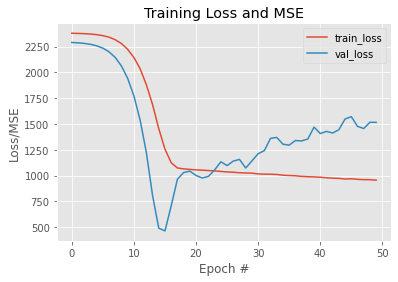

In [ ]:
import matplotlib.pyplot as plt
# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), HFinal.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), HFinal.history["val_loss"], label="val_loss")
plt.title("Training Loss and MSE")
plt.xlabel("Epoch #")
plt.ylabel("Loss/MSE")
plt.legend()

In [ ]:
results_by_test = new_test['FVC'].values
patientes_by_test = new_test[new_test.keys()].copy()
del patientes_by_test['FVC']
display(patientes_by_test)
len(results_by_test)

,Patient,Weeks,Percent,Age,Sex_M,Sex_F,SmokingStatus_Ex,SmokingStatus_N,SmokingStatus_S,Patient_by_week,min_week,base_FVC,base_week
85,10.0,6,0.484482,0.416667,0,0,1,0,0,84.0,6,0.609272,0
86,11.0,15,0.694580,0.208333,0,0,1,0,0,85.0,15,0.511328,0
87,12.0,6,0.599389,0.416667,0,0,1,0,0,86.0,6,0.229348,0
88,13.0,17,0.645213,0.375000,0,0,1,0,0,87.0,17,0.704775,0
89,14.0,0,0.513505,0.416667,0,0,0,1,0,88.0,0,0.576159,0


5

In [ ]:
random_images_test = np.expand_dims(random_images_test, axis=-1)
predictions_final = model_combinado.predict([random_images_test, patientes_by_test])
print(predictions_final)

[[3400.3423]
 [3674.0413]
 [3503.3447]
 [3852.2488]
 [3451.549 ]]


In [ ]:
model_combinado.evaluate([random_images_test, patientes_by_test], results_by_test)

1/1 [==============================] - 2s 2s/step - loss: 794.7052


794.7052001953125

In [ ]:
for i in list(range(0, 5)):
  print(predictions_final[i], results_by_test[i], predictions_final[i] - results_by_test[i])

[3400.3423] 3020 [380.3423]
[3674.0413] 2739 [935.04126]
[3503.3447] 1930 [1573.3447]
[3852.2488] 3294 [558.2488]
[3451.549] 2925 [526.5491]
